# Importing the Necessary Packages

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Loading in the data

In [7]:
train_data = pd.read_csv("/Users/adarsh/Workspace/Personal/Machine-Learning-Classification/data/train.csv")
test_data = pd.read_csv("/Users/adarsh/Workspace/Personal/Machine-Learning-Classification/data/test.csv")

In [8]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### We are now going to use only the `text` and `target` columns.

* 1 - Disaster Tweet
* 0 - Not a Disaster Tweet

## Visualizing the target distribution of the data

<Axes: xlabel='target'>

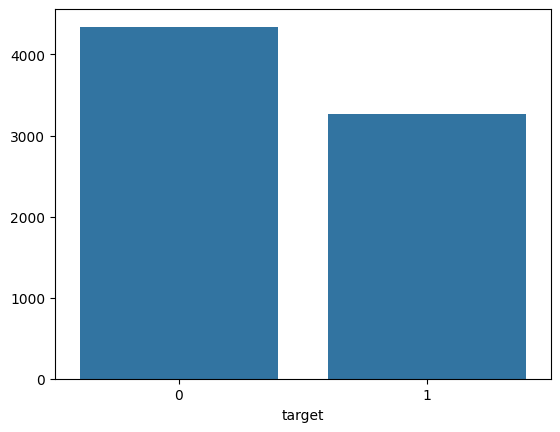

In [14]:
sns.barplot(x=train_data['target'].value_counts().index, y=list(train_data['target'].value_counts()))

## Plotting a word cloud to see which words occur the most

In [16]:
full_text = " ".join(text for text in train_data.text)

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(full_text)


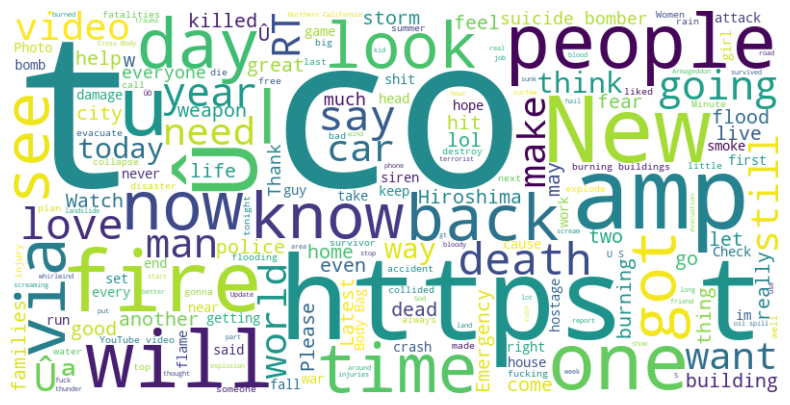

In [20]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis details
plt.show()

## Training a Count Vectorizer Model

In [21]:
train_data = train_data[["text", "target"]]

In [22]:
X = train_data["text"]
y = train_data["target"]

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

In [36]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_val_cv = cv.transform(X_val)

We are first going to try a linear SVC model as recommended by the sklearn documentation - https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html
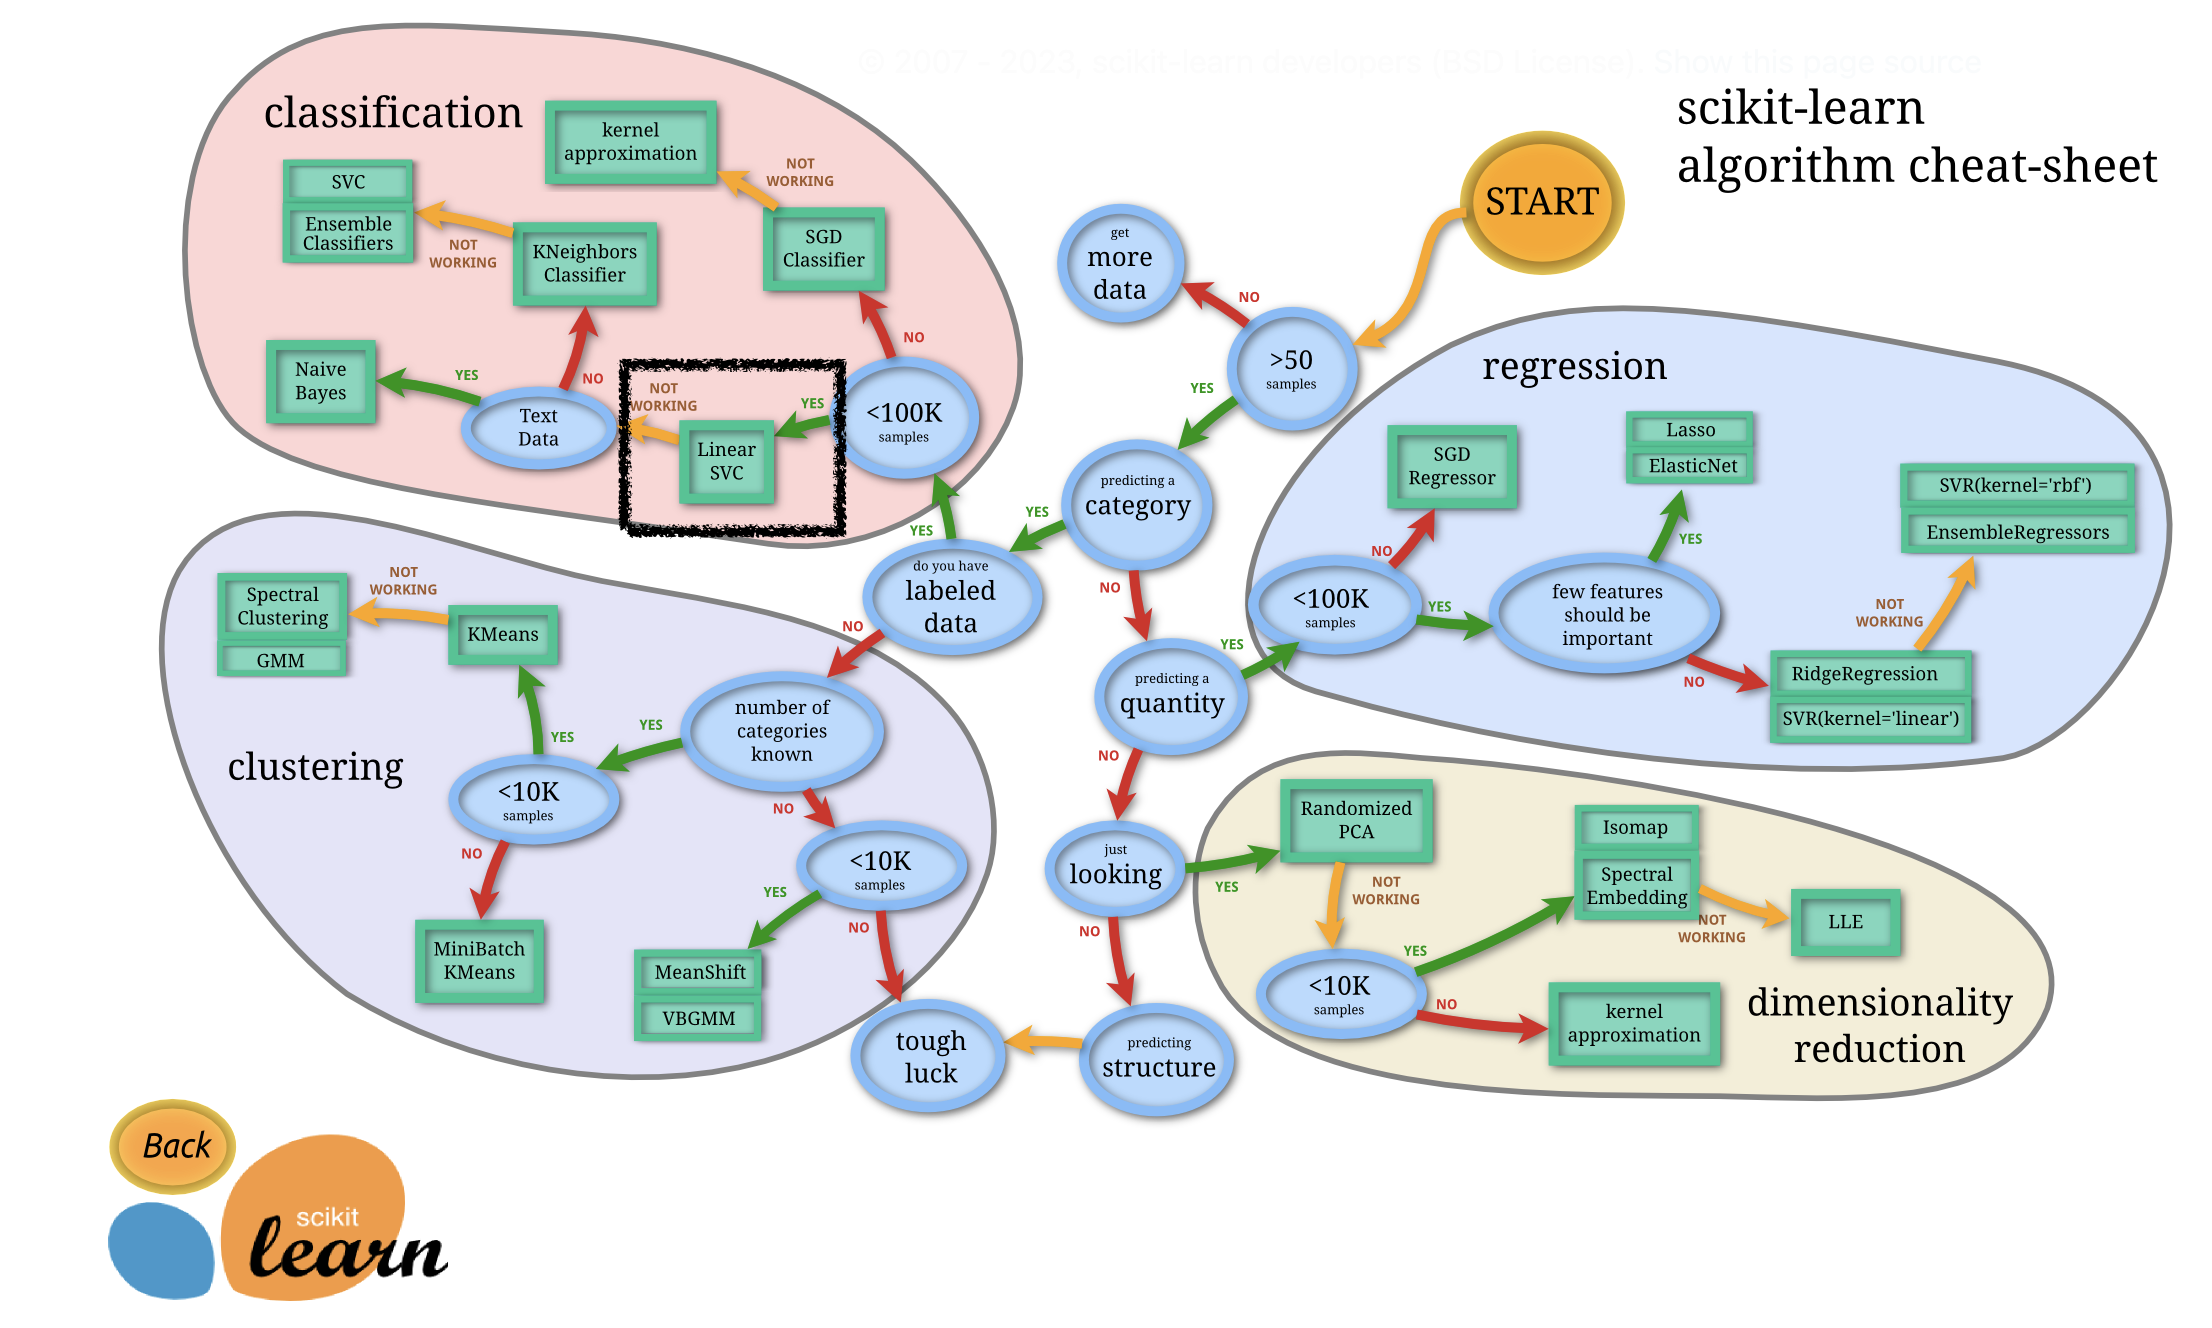


In [29]:
from sklearn.svm import SVC

In [31]:
svc_count_vc = SVC(probability=True)
svc_count_vc.fit(X_train_cv, y_train)

SVC(probability=True)

In [37]:
y_pred = svc_count_vc.predict(X_val_cv)
y_pred_proba = svc_count_vc.predict_proba(X_val_cv)

## Logging Metrics on Weights and Biases

### Step 1: Login to Weights and Biases

In [34]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/adarsh/.netrc


True

### Step 2: Initialize Project

In [35]:
wandb.init(project="Disaster Tweet Classification")

wandb: Currently logged in as: adarsh047. Use `wandb login --relogin` to force relogin


### Step 3: Log Classifier Into the dashboard

In [41]:
labels = ["Not a Disaster", "Disaster"]

In [42]:
wandb.sklearn.plot_classifier(model=svc_count_vc, X_train=X_train_cv, X_test=X_val_cv, y_train=y_train, y_test=y_val, y_pred=y_pred, y_probas=y_pred_proba, model_name="SVC Count Vectorizer", labels=labels)

wandb: 
wandb: Plotting SVC Count Vectorizer.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


### Step 4: Log Classifier Metrics

In [44]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')
conf_matrix = confusion_matrix(y_val, y_pred)


In [54]:
metrics_table = wandb.Table(columns=["Metric", "Value"])
metrics_table.add_data("Accuracy", accuracy)
metrics_table.add_data("Precision", precision)
metrics_table.add_data("Recall", recall)
metrics_table.add_data("F1 Score", f1)

In [52]:
wandb.log({
    "metrics": metrics_table})

In [55]:
wandb.log({
    "metrics bar plot": wandb.plot.bar(metrics_table, "Metric", "Value",
                              title="Model Metrics")
})
